In [1]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#from wordcloud import WordCloud
import pandas as pd
import numpy as np
from datetime import datetime
import os
import string
from nltk.probability import FreqDist

In [2]:
def read_txt_data(filename):
    with open(filename) as f:
        return [line.rstrip().split(",") for line in f]
    
def read_txt_label(filename):
    with open(filename) as f:
        return [line.rstrip() for line in f]

In [3]:
covid_data = read_txt_data('./covid.data.txt')
covid_label = read_txt_label('./covid_label.txt')


In [4]:
def preprocess_data(data):
    
    # date: year, month, day
    data['datetime_obj'] = datetime.strptime(data['created_at'], '%Y-%m-%dT%H:%M:%S.%fZ')
    
    return {
        'id': data['id'],
        #'year': int(data['datetime_obj'].year), 
        'month': int(data['datetime_obj'].month),
        'text': data['text'], 
        #'lang': data['lang'],
        'retweet_count': data['public_metrics']['retweet_count'],
        #'verified': int(data['user']['verified']),
        #'followers_count': data['user']['followers_count'],
        'favorite_count': data['public_metrics']['like_count'],
        'reply_count': data['public_metrics']['reply_count']
        #'location': data['user']['location']
    }

def preprocess_user(data):
    return {
        #'id': data['id'],
        #'year': int(data['datetime_obj'].year), 
        #'month': int(data['datetime_obj'].month),
        #'text': data['text'], 
        #'lang': data['lang'],
        #'retweet_count': data['user']['retweet_count'],
        'verified': int(data['user']['verified']),
        'followers_count': data['user']['followers_count'],
        #'favorite_count': data['public_metrics']['like_count'],
        'location': data['user']['location']
    }

In [5]:
# 先做15956 的covid tweet 这个是feed给分类器的 
# include text, created_at, like_count, retweet_count
# 还需要include location, follower count
# check duplicate tweet, combine 墨学 和自己的covid tweet
filename_tweets= './covid_object/{}.json' # covid_object contains user info

rumor_list = list() # store rumor tweets ids
nonrumor_list = list() # store non-rumor tweets ids
r_reply = list() # store the id of rumor replies
nonr_reply = list() # store the id of nonrumor replies
counter = 0
for data in covid_data:
    if not os.path.exists(filename_tweets.format(data[0])):
        continue
    if covid_label[counter] == '1':
        rumor_list.append(data[0])
        for d in data[1:]:
            r_reply.append(d)
    else:
        nonrumor_list.append(data[0])
        for d in data[1:]:
            nonr_reply.append(d)
    counter += 1

#rumor_df = pd.DataFrame(rumor_list)
#nonrumor_df = pd.DataFrame(nonrumor_list)

In [9]:
# 分rumor的reply 和nonrumor 的reply 
filename = './analysis_tweet/{}.json' # analysis_tweet contains full text tweets
rumor_reply = list()
nonrumor_reply = list()

# read tweets of rumor replies
for data in r_reply:
    if not os.path.exists(filename.format(data)):
        continue
    rumor_reply.append(preprocess_data(json.load(open(filename.format(data)))))

for data in nonr_reply:
    if not os.path.exists(filename.format(data)):
        continue
    nonrumor_reply.append(preprocess_data(json.load(open(filename.format(data)))))


In [11]:
rumor_reply_df = pd.DataFrame(rumor_reply)
nonrumor_reply_df = pd.DataFrame(nonrumor_reply)

In [12]:
def preprocess(text):
    new_text = []
    text = text.replace('\n', ' ') # replace newline with whitespace
    for t in text.split(" "):
        if not t.startswith('@') and not t.startswith('http'):
            if t.startswith('#'):
                t = t[1:]
            new_text.append(t)
    return " ".join(new_text)

rumor_text = [preprocess(x) for x in rumor_reply_df['text']] # stores rumor text without https, @, and hashtags
nonrumor_text = [preprocess(x) for x in nonrumor_reply_df['text']] # stores nonrumor text without https, @, and hashtags


In [14]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Win10\AppData\Roaming\nltk_data...


True

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [17]:
# Sentiment analysis of rumor and nonrumor tweets
rumor_sent = list()
for tweet in rumor_text:
    ps = analyzer.polarity_scores(tweet)
    rumor_sent.append({'text':tweet, 'compound':ps['compound']})

nonrumor_sent = list()
for tweet in nonrumor_text:
    ps = analyzer.polarity_scores(tweet)
    nonrumor_sent.append({'text':tweet, 'compound':ps['compound']})

In [19]:
rumor_sent_df = pd.DataFrame(rumor_sent)
nonrumor_sent_df = pd.DataFrame(nonrumor_sent)

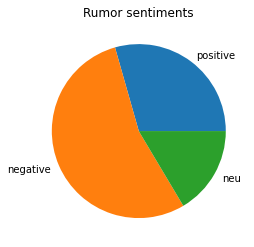

In [20]:
# draw pie chart for rumor sentiment
rumor_pos = 0
rumor_neg = 0
rumor_neu = 0
for i in rumor_sent_df['compound']:
    if i > 0:
        rumor_pos +=1
    elif i < 0:
        rumor_neg += 1
    else:
        rumor_neu += 1
        
compounds = np.array([rumor_pos, rumor_neg, rumor_neu])
labels = ['positive', 'negative', 'neu']
plt.pie(compounds, labels = labels)
plt.title("Rumor sentiments")
plt.show()

In [21]:
print("Rumor sentiments")
print(compounds)

Rumor sentiments
[13563 24968  7584]


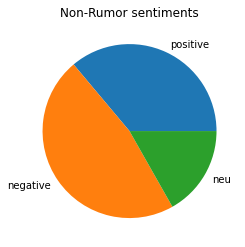

In [22]:
# draw pie chart for nonrumor sentiment
nonrumor_pos = 0
nonrumor_neg = 0
nonrumor_neu = 0
for i in nonrumor_sent_df['compound']:
    if i > 0:
        nonrumor_pos +=1
    elif i < 0:
        nonrumor_neg += 1
    else:
        nonrumor_neu += 1
        
compounds = np.array([nonrumor_pos, nonrumor_neg, nonrumor_neu])
labels = ['positive', 'negative', 'neu']
plt.pie(compounds, labels = labels)
plt.title("Non-Rumor sentiments")
plt.show()

In [23]:
print("Non-Rumor sentiments")
print(compounds)

Non-Rumor sentiments
[30296 39502 14088]
